In [2]:
from itertools import product, permutations
import math
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    aes,
    theme, 
    element_text,
    stat_smooth,
    facet_wrap,
    geom_tile,
    geom_point,
    geom_histogram,
    geom_violin,
    geom_col,
    xlab,
    ylab,
    ggtitle,
    geom_line,
    geom_ribbon,
    geom_vline,
    geom_text,
    scale_x_log10,
    scale_x_reverse,
    geom_boxplot
)
import polars as pl
import torch
import functorch
from sklearn import linear_model



from sngrok.cosets import get_left_cosets, get_right_cosets, make_left_full_coset_df, make_right_full_coset_df

from sngrok.fourier import slow_sn_ft_1d, slow_sn_ft_2d, sn_fourier_basis, sn_fourier_basis_2d, calc_power
from sngrok.groups import generate_subgroup, Symmetric
from sngrok.permutations import Permutation
from sngrok.model import SnMLP
from sngrok.tableau import generate_partitions
from sngrok.irreps import SnIrrep

from confection import Config

In [4]:
from torch.nn.functional import relu
from copy import deepcopy


def loss_fn(logits, labels):
    if len(logits.shape) == 3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])
    return -1. * correct_log_probs


def calc_power_contributions(tensor, n):
    total_power = (tensor ** 2).mean(dim=0)
    group_order = math.factorial(n)
    fourier_transform = slow_sn_ft_1d(tensor, n)
    irrep_power = calc_power(fourier_transform, group_order)
    power_contribs = {irrep: power / total_power for irrep, power in irrep_power.items()}
    irreps = list(power_contribs.keys())
    power_vals = torch.cat([power_contribs[irrep].unsqueeze(0) for irrep in irreps], dim=0)
    val_data = pl.DataFrame(power_vals.detach().cpu().numpy(), schema=[f'dim{i}' for i in range(tensor.shape[1])])
    val_data.insert_at_idx(0, pl.Series('irrep', [str(i) for i in irreps]))
    return val_data, fourier_transform


def fourier_basis_to_df(tensor, n, layer):
    group_order, num_irreps, fn_dim = tensor.shape
    all_partitions = generate_partitions(n)
    permutations = Permutation.full_group(n)
    assert len(permutations) == group_order
    assert len(all_partitions) == num_irreps
    
    long_values = tensor.reshape((-1, fn_dim))
    group_col= []
    for s in permutations:
        group_col += [str(s.sigma)] * num_irreps
    part_col = [str(p) for p in all_partitions] * group_order
    assert len(group_col) == len(part_col) and len(group_col) == long_values.shape[0]
    val_data = pl.DataFrame(long_values.detach().numpy(), schema=[f'dim{i}' for i in range(fn_dim)])
    sn_metadata = pl.DataFrame({'layer': [layer] * len(group_col), 'permutation': group_col, 'irrep': part_col})
    return pl.concat([sn_metadata, val_data], how='horizontal')


In [5]:
def add_neuron_classification(data):
    return (
        data.
        with_columns(
            pl.when(pl.col('two_norm') < 1.0)
            .then(pl.lit('Off'))
            .when(pl.col('coset_var_ratio') < 1.0)
            .then(pl.col('subgroup'))
            .otherwise(pl.lit('None'))
            .alias('neuron_classification')
        )
    )

In [6]:
small_coset_path = Path('/Users/dashiell/Documents/sn-circuits/small/')

cols = ['epoch', 'layer', 'variable', 'subgroup', 'min_coset_var', 'coset_var_ratio', 'full_var', 'two_norm', 'subgroup_class', 'neuron_classification']


small_coset_data = []

for i in range(128):
    left = pl.scan_parquet(small_coset_path / f'left_cosets/{i}.parquet')
    right = pl.scan_parquet(small_coset_path / f'right_cosets/{i}.parquet')
    
    left = add_neuron_classification(left).select(cols).rename({
        'subgroup': 'left_subgroup',
        'min_coset_var': 'left_min_coset_var',
        'coset_var_ratio': 'left_coset_var_ratio',
        'full_var': 'left_full_var',
        'two_norm': 'left_two_norm', 
        'subgroup_class': 'left_subgroup_class', 
        'neuron_classification': 'left_neuron_classification'
    })
    right = add_neuron_classification(right).rename({
        'subgroup': 'right_subgroup',
        'min_coset_var': 'right_min_coset_var',
        'coset_var_ratio': 'right_coset_var_ratio',
        'full_var': 'right_full_var',
        'two_norm': 'right_two_norm', 
        'subgroup_class': 'right_subgroup_class', 
        'neuron_classification': 'right_neuron_classification'
    })
    merged = left.join(right, on=['epoch', 'variable'])
    data = merged.collect()
    data.insert_at_idx(0, pl.Series('seed', [i] * data.shape[0]))
    small_coset_data.append(data)
                                
small_coset_df = pl.concat(small_coset_data)

cosets_data = (
    small_coset_df.with_columns(
        left_neuron_class = pl.col('left_neuron_classification').str.split(by='_').list.get(0),
        right_neuron_class = pl.col('right_neuron_classification').str.split(by='_').list.get(0),
        neuron_class_pair = '(' + pl.col('left_neuron_classification') + ', ' + pl.col('right_neuron_classification') + ')'
    )
)

In [10]:
cosets_data.filter((pl.col('epoch') == 249999) & (pl.col('right_neuron_classification') == 'None')).groupby('seed').count()

seed,count
i64,u32
21,1
75,17
28,6
64,34
67,27
47,1
93,1
57,3
62,3


In [16]:
cosets_data.filter(
    (pl.col('epoch') == 249999) & 
    (pl.col('left_neuron_classification') == 'None') &
    (pl.col('seed') == 28)
)
# Both: 45, 53, 60, 69
# Right: 38, 113


seed,epoch,layer,variable,left_subgroup,left_min_coset_var,left_coset_var_ratio,left_full_var,left_two_norm,left_subgroup_class,left_neuron_classification,layer_right,right_subgroup,right_min_coset_var,mean,min,max,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,right_neuron_classification,left_neuron_class,right_neuron_class,neuron_class_pair
i64,i64,str,str,str,f32,f32,f32,f32,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,str,str
28,249999,"""left_linear""","""dim69""","""A5_0""",4.359915,2.012122,2.166825,257.863037,"""A5""","""None""","""right_linear""","""A5_0""",4.044626,0.008858,-2.533136,2.400976,2.014418,239.725204,2.007838,"""A5""","""None""","""None""","""None""","""(None, None)"""
28,249999,"""left_linear""","""dim45""","""A5_0""",7.043285,1.998084,3.52502,419.558136,"""A5""","""None""","""right_linear""","""A5_0""",6.781007,0.01375,-3.243962,3.388217,3.363817,400.316956,2.015867,"""A5""","""None""","""None""","""None""","""(None, None)"""
28,249999,"""left_linear""","""dim53""","""S3_twisted_4""",6.125156,1.669349,3.669188,436.701813,"""S3""","""None""","""right_linear""","""A5_0""",7.153419,0.017416,-3.559196,3.198335,3.555406,423.129669,2.011984,"""A5""","""None""","""None""","""None""","""(None, None)"""
28,249999,"""left_linear""","""dim60""","""A5_0""",6.338436,2.002957,3.164539,376.635345,"""A5""","""None""","""right_linear""","""C2_double_tran…",3.322824,0.009483,-2.851328,3.022161,2.952614,351.371826,1.125384,"""C2""","""None""","""None""","""None""","""(None, None)"""


In [11]:
def fourier_stats(model_seed, n):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's{n}_40_{model_seed}'
    Sn = Symmetric(n)

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    model_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    config = model_run['config']
    embed_dim = config['embed_dim']

    model = SnMLP.from_config(model_run['config'])
    model.load_state_dict(model_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    
    W = model.linear.weight

    lpower_df, llinear_ft = calc_power_contributions(model.lembed.weight @ W[:, :embed_dim].T, n)
    rpower_df, rlinear_ft = calc_power_contributions(model.rembed.weight @ W[:, embed_dim:].T, n)
    unembed_power_df, unembed_ft = calc_power_contributions(model.unembed.weight, n)
    num_rows = lpower_df.shape[0]
    
    lpower_df.insert_at_idx(0, pl.Series('layer', ['left_linear'] * num_rows))
    rpower_df.insert_at_idx(0, pl.Series('layer', ['right_linear'] * num_rows))
    unembed_power_df.insert_at_idx(0, pl.Series('layer', ['unembed'] * num_rows))
    power_df = pl.concat([lpower_df, rpower_df, unembed_power_df], how='vertical').melt(id_vars=['layer', 'irrep'])
    
    llinear_decomp = sn_fourier_basis(llinear_ft, Sn)
    rlinear_decomp = sn_fourier_basis(rlinear_ft, Sn)
    unembed_decomp = sn_fourier_basis(unembed_ft, Sn)
    
    llinear_df = fourier_basis_to_df(llinear_decomp, n, 'left_linear')
    rlinear_df = fourier_basis_to_df(rlinear_decomp, n, 'right_linear')
    unembed_df = fourier_basis_to_df(unembed_decomp, n, 'unembed')
        
    
    return llinear_df, rlinear_df, unembed_df, power_df 
    


In [13]:
llinear_df, rlinear_df, unembed_df, power_df = fourier_stats(28, 5)

In [37]:
#power_df.filter(pl.col('irrep') == '(2, 1, 1, 1)').sort('value').tail(10)
# 

In [45]:
from sngrok.proper_subgroups import all_s5_subgroups

def _make_one_coset_df(sg_def, n, name):
        all_subgroups = [generate_subgroup(gen) for gen in sg_def['generators']]
        right_coset_df = make_right_full_coset_df(all_subgroups, n, name)
        left_coset_df = make_left_full_coset_df(all_subgroups, n, name)
        return left_coset_df, right_coset_df
        
        

def make_full_coset_df(all_subgroups, n):
        left_cosets = []
        right_cosets = []
        
        for subgroup_name, subgroup_info in all_subgroups.items():
            ldf, rdf =  _make_one_coset_df(subgroup_info, n, subgroup_name)
            left_cosets.append(ldf)
            right_cosets.append(rdf)

        left_df = pl.concat(left_cosets)
        right_df = pl.concat(right_cosets)
        
        return left_df, right_df

full_left_coset_df, full_right_coset_df = make_full_coset_df(all_s5_subgroups, 5)

In [36]:
cosets28 = cosets_data.filter(
    (pl.col('epoch') == 249999) & (pl.col('seed') == 28)
)
cosets28.filter(pl.col('variable').is_in(['dim127', 'dim63', 'dim68', 'dim24', 'dim48']))

seed,epoch,layer,variable,left_subgroup,left_min_coset_var,left_coset_var_ratio,left_full_var,left_two_norm,left_subgroup_class,left_neuron_classification,layer_right,right_subgroup,right_min_coset_var,mean,min,max,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,right_neuron_classification,left_neuron_class,right_neuron_class,neuron_class_pair
i64,i64,str,str,str,f32,f32,f32,f32,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,str,str
28,249999,"""left_linear""","""dim63""","""A4_4""",0.081086,0.012292,6.596441,785.005676,"""A4""","""A4_4""","""right_linear""","""A4_1""",0.241474,-0.00932,-3.415356,3.506673,6.899615,821.064697,0.034998,"""A4""","""A4_1""","""A4""","""A4""","""(A4_4, A4_1)"""
28,249999,"""left_linear""","""dim127""","""A4_4""",0.084107,0.017577,4.785187,569.441589,"""A4""","""A4_4""","""right_linear""","""A4_3""",0.141468,-0.002766,-3.31299,3.187877,4.736446,563.637939,0.029868,"""A4""","""A4_3""","""A4""","""A4""","""(A4_4, A4_3)"""
28,249999,"""left_linear""","""dim24""","""A4_4""",0.016264,0.004231,3.844435,457.488892,"""A4""","""A4_4""","""right_linear""","""A4_3""",0.039106,-0.000249,-2.963861,3.004341,3.827846,455.513733,0.010216,"""A4""","""A4_3""","""A4""","""A4""","""(A4_4, A4_3)"""
28,249999,"""left_linear""","""dim48""","""A4_4""",0.016257,0.003848,4.225055,502.783478,"""A4""","""A4_4""","""right_linear""","""A4_3""",0.04153,0.002052,-3.008526,3.022854,4.169925,496.221558,0.009959,"""A4""","""A4_3""","""A4""","""A4""","""(A4_4, A4_3)"""
28,249999,"""left_linear""","""dim68""","""S3_twisted_4""",1.384853,0.506261,2.735451,325.564758,"""S3""","""S3_twisted_4""","""right_linear""","""S3_twisted_6""",0.935455,-0.003198,-2.502411,2.573484,2.526296,300.630493,0.370287,"""S3""","""S3_twisted_6""","""S3""","""S3""","""(S3_twisted_4,…"


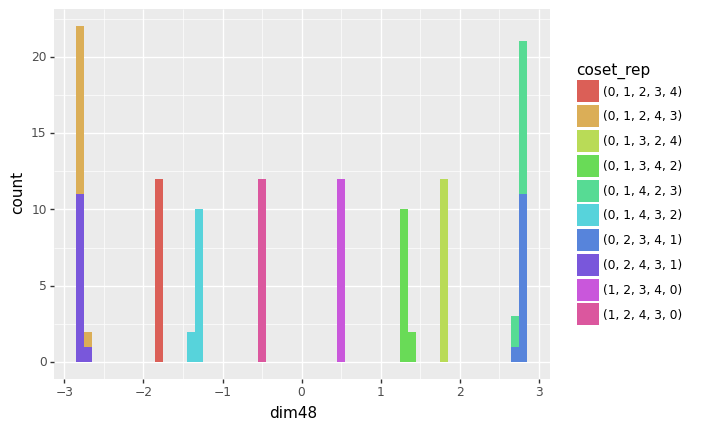

<ggplot: (702964004)>

In [46]:
# Other (2, 1, 1, 1) cols: 'dim127', 'dim63', 'dim68', 'dim24', 'dim48'
num = 48
col = f'dim{num}'
df = llinear_df.filter(pl.col('irrep') == '(2, 1, 1, 1)').select(['permutation', 'irrep', col])
df = df.join(full_right_coset_df.filter(pl.col('subgroup') == 'A4_4'), on = 'permutation')
ggplot(
    df,
    aes(x = col, fill='coset_rep')
) + geom_histogram(binwidth=0.1) #+ facet_wrap('~irrep', scales='free')

In [48]:
left_base_df = llinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())
right_base_df = rlinear_df.melt(id_vars=['layer', 'permutation', 'irrep']).groupby(['layer', 'permutation', 'variable']).agg(pl.col('value').sum())

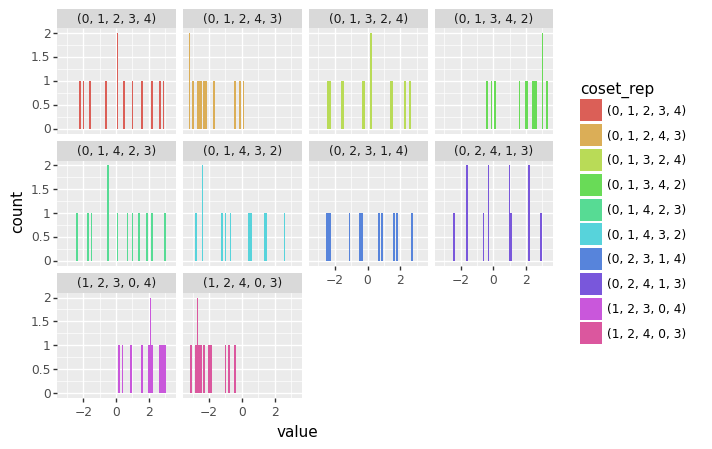

<ggplot: (710368016)>

In [89]:
# Both: 45, 53, 60, 69
#power_df.filter(pl.col('variable') == 'dim69' )
num = 53
col = f'dim{num}'

df = (
    left_base_df
    .filter(pl.col('variable') == col)
    .join(
        #full_right_coset_df.filter(pl.col('subgroup').str.starts_with('A4')),
        full_right_coset_df.filter(pl.col('subgroup') == 'A4_3'),
        on='permutation'
    )
)
    
ggplot(
    df,
    aes(x = 'value', fill='coset_rep')
) + geom_histogram(binwidth=0.1) + facet_wrap('~coset_rep')


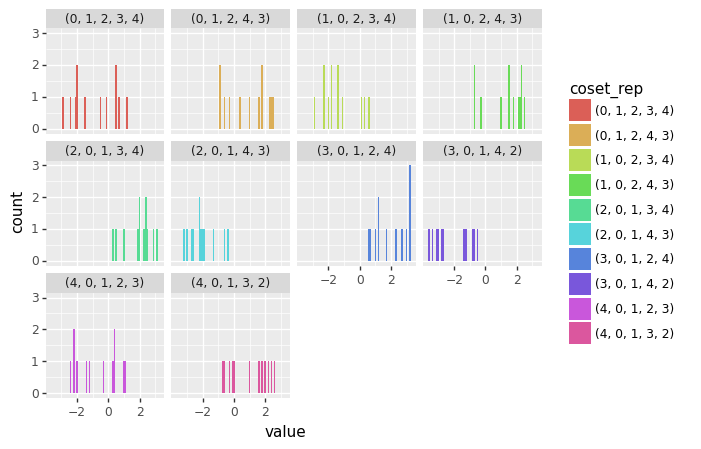

<ggplot: (705832471)>

In [91]:

df = (
    right_base_df
    .filter(pl.col('variable') == col)
    .join(
        #full_left_coset_df.filter(pl.col('subgroup').str.starts_with('S3')),
        full_right_coset_df.filter(pl.col('subgroup') == 'A4_0'),
        on='permutation'
    )
)
    
ggplot(
    df,
    aes(x = 'value', fill='coset_rep')
) + geom_histogram(binwidth=0.1) + facet_wrap('~coset_rep')


In [56]:
def get_linear_layer_decomp(model_seed):
    ckpt_dir = Path('/Users/dashiell/workspace/sn-grok/s5_40_small')
    run_name = f's5_40_{model_seed}'

    #whole_config = Config().from_disk('configs/s5_lr_5.toml')
    run_dir = ckpt_dir / run_name
    full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
    run_data = pl.read_parquet(run_dir / f'data.parquet')
    lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
    rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
    targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()
    
    #full_left_coset_df, full_right_coset_df = make_full_coset_df()
    
    #checkpoint_epochs = full_run['checkpoint_epochs'] + [249999]
    #checkpoint_paths = sorted([fp for fp in run_dir.glob('*.pth')], key=fp_sort_key)
    
    model = SnMLP.from_config(full_run['config'])
    model.load_state_dict(full_run['model'])

    logits, cache = model.run_with_cache(lperms, rperms)
    loss = loss_fn(logits, targets)

    linear_acts = cache['hook_linear']
    df = pl.concat(
        [run_data, pl.DataFrame(linear_acts.detach().numpy(), schema=[f'dim{i}' for i in range(linear_acts.shape[1])])],
        how='horizontal'
    )
    return df.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
    

In [57]:
linear28 = get_linear_layer_decomp(28)

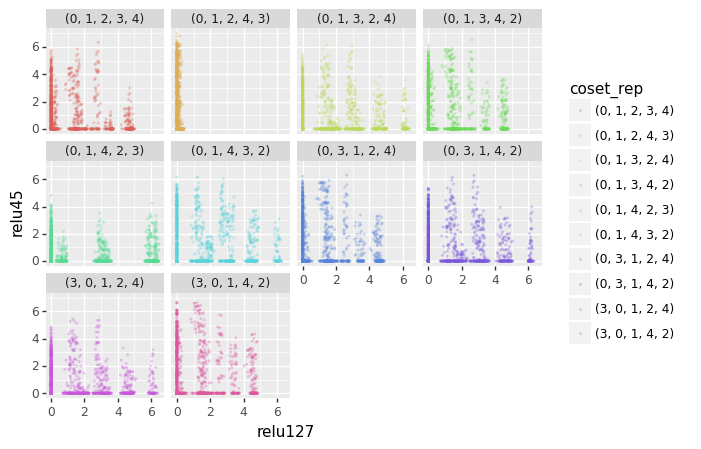

<ggplot: (709840833)>

In [151]:
num = 24
col = f'dim{num}'
sg_num = 0

df = (
    linear28
    .select(['permutation_target', 'dim45', 'dim127'])
    .rename({'permutation_target': 'permutation'})
    .join(
        #full_left_coset_df.filter(pl.col('subgroup').str.starts_with(f'S4')),
        full_left_coset_df.filter(pl.col('subgroup') == f'A4_3'),
        on='permutation'
    )
    .with_columns(
        relu127=pl.col('dim127').clip_min(0.0),
        relu45=pl.col('dim45').clip_min(0.0),
        
        total=pl.col('dim45').clip_min(0.0) + pl.col('dim127').clip_min(0.0))
)

ggplot(
    df,
    aes(x='relu127', y='relu45', color='coset_rep')
    #aes(x='total', fill='coset_rep')
) + geom_point(alpha=0.2, size=0.3) + facet_wrap('~coset_rep')

In [92]:
unembed_base = (
    unembed_df
    .select(pl.exclude('irrep'))
    .groupby(['layer', 'permutation']).sum()
)

In [93]:
cosets28.head()

seed,epoch,layer,variable,left_subgroup,left_min_coset_var,left_coset_var_ratio,left_full_var,left_two_norm,left_subgroup_class,left_neuron_classification,layer_right,right_subgroup,right_min_coset_var,mean,min,max,right_full_var,right_two_norm,right_coset_var_ratio,right_subgroup_class,right_neuron_classification,left_neuron_class,right_neuron_class,neuron_class_pair
i64,i64,str,str,str,f32,f32,f32,f32,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,str,str,str,str,str
28,249999,"""left_linear""","""dim118""","""A4_3""",0.040416,0.005714,7.072712,841.676697,"""A4""","""A4_3""","""right_linear""","""A4_0""",0.022428,-0.004801,-3.934475,3.91797,7.058145,839.922119,0.003178,"""A4""","""A4_0""","""A4""","""A4""","""(A4_3, A4_0)"""
28,249999,"""left_linear""","""dim37""","""A4_0""",0.040884,0.006172,6.624401,788.303894,"""A4""","""A4_0""","""right_linear""","""A4_0""",0.031357,0.011215,-3.327331,3.326429,6.632779,789.315857,0.004728,"""A4""","""A4_0""","""A4""","""A4""","""(A4_0, A4_0)"""
28,249999,"""left_linear""","""dim111""","""A4_2""",0.12177,0.0167,7.291423,867.682312,"""A4""","""A4_2""","""right_linear""","""A4_0""",0.073818,-0.007149,-3.972691,3.997311,7.303842,869.163513,0.010107,"""A4""","""A4_0""","""A4""","""A4""","""(A4_2, A4_0)"""
28,249999,"""left_linear""","""dim84""","""A4_4""",0.057777,0.006508,8.878427,1056.554688,"""A4""","""A4_4""","""right_linear""","""A4_0""",0.026307,-0.008011,-4.122235,4.199076,8.810187,1048.420044,0.002986,"""A4""","""A4_0""","""A4""","""A4""","""(A4_4, A4_0)"""
28,249999,"""left_linear""","""dim89""","""A4_0""",0.027995,0.005277,5.304843,631.277161,"""A4""","""A4_0""","""right_linear""","""A4_0""",0.072428,-0.006672,-2.999826,3.003299,5.197094,618.459473,0.013936,"""A4""","""A4_0""","""A4""","""A4""","""(A4_0, A4_0)"""


In [96]:
subgroup_counts = (
    cosets28
    #.filter(pl.col('subgroup_pair') == "(s4_0, s4_0)")
    #.filter(pl.col('left_subgroup') == "s4_0")
    .groupby('neuron_class_pair').count()
    .sort('count')
)

unembed_cols = (
    cosets28
    .join(subgroup_counts, on='neuron_class_pair')
    .sort(['count', 'neuron_class_pair', 'variable'])
    .select('variable')
)['variable'].to_list()


In [98]:
coset_pairs = (
    cosets28
    .select(['variable', 'neuron_class_pair'])
)
corrs = unembed_base.select(unembed_cols).corr()
corrs.insert_at_idx(0, pl.Series('left_cols', unembed_cols))
corr_df = corrs.melt(id_vars='left_cols', variable_name='right_cols')
corr_df = corr_df.join(coset_pairs, left_on='left_cols', right_on='variable').rename({'neuron_class_pair': 'left_coset'})
corr_df = corr_df.join(coset_pairs, left_on='right_cols', right_on='variable').rename({'neuron_class_pair': 'right_coset'})


In [114]:
#coset_pairs.filter(pl.col('neuron_class_pair') == "(A4_4, A4_3)")
coset_pairs.filter(pl.col('neuron_class_pair') == "(None, None)")

variable,neuron_class_pair
str,str
"""dim69""","""(None, None)"""
"""dim45""","""(None, None)"""
"""dim53""","""(None, None)"""
"""dim60""","""(None, None)"""


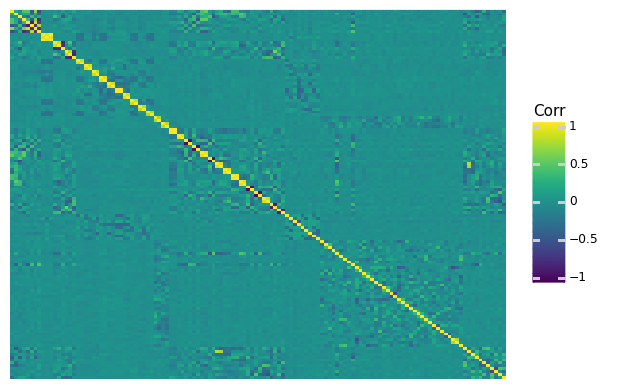

<ggplot: (709796435)>

In [103]:
from plotnine import element_blank, scale_x_discrete, scale_y_discrete, scale_fill_continuous, labs

fig = (
    ggplot(corr_df, aes(x='left_cols', y='right_cols', fill='value')) 
    + geom_tile() 
    + scale_x_discrete(limits=unembed_cols[::-1], labels=[])
    + scale_y_discrete(limits=unembed_cols, labels=[])
    + scale_fill_continuous(limits=[-1, 1])
    + labs(fill='Corr', x='', y='')
    + theme(axis_ticks=element_blank())
)
fig

In [115]:
# 'dim127', 'dim63', 'dim68', 'dim24', 'dim48'
(
    corr_df
    .filter(pl.col('left_cols') == 'dim45')
    .groupby('right_coset')
    .agg(
        count=pl.count(),
        mean=pl.col('value').mean(),
        minimum=pl.col('value').min(),
        maximum=pl.col('value').max()
    )
    .sort('minimum')
)

right_coset,count,mean,minimum,maximum
str,u32,f64,f64,f64
"""(A4_4, A4_3)""",4,-0.057597,-0.704145,0.608964
"""(A4_4, A4_1)""",2,-0.064354,-0.46844,0.339731
"""(A4_4, A4_2)""",2,-0.055875,-0.380511,0.268762
"""(A4_0, A4_1)""",2,-0.096395,-0.306175,0.113384
"""(A4_0, A4_3)""",2,-0.05047,-0.269847,0.168906
"""(A4_2, A4_2)""",2,-0.146255,-0.200639,-0.091871
"""(A4_0, A4_0)""",3,0.04618,-0.193308,0.202789
"""(A4_0, A4_2)""",3,-0.05333,-0.179884,0.14319
"""(S3_twisted_4,…",1,-0.125633,-0.125633,-0.125633


In [118]:
a4_none_cols = (
    cosets28
    .join(subgroup_counts, on='neuron_class_pair')
    .sort(['count', 'neuron_class_pair', 'variable'])
    .filter(pl.col('neuron_class_pair').is_in(['(None, None)', '(A4_4, A4_3)']))
    .select('variable')
)['variable'].to_list()

coset_pairs = (
    cosets28
    .select(['variable', 'neuron_class_pair'])
    .filter(pl.col('neuron_class_pair').is_in(['(None, None)', '(A4_4, A4_3)']))
)
small_corrs = unembed_base.select(a4_none_cols).corr()
small_corrs.insert_at_idx(0, pl.Series('left_cols', a4_none_cols))
small_df = small_corrs.melt(id_vars='left_cols', variable_name='right_cols')
small_df = small_df.join(coset_pairs, left_on='left_cols', right_on='variable').rename({'neuron_class_pair': 'left_coset'})
small_df = small_df.join(coset_pairs, left_on='right_cols', right_on='variable').rename({'neuron_class_pair': 'right_coset'})


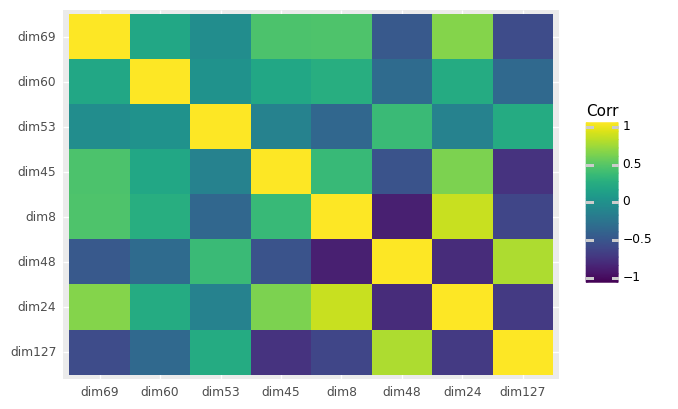

<ggplot: (708106661)>

In [122]:
fig = (
    ggplot(small_df, aes(x='left_cols', y='right_cols', fill='value')) 
    + geom_tile() 
    + scale_x_discrete(limits=a4_none_cols[::-1])
    + scale_y_discrete(limits=a4_none_cols)
    + scale_fill_continuous(limits=[-1, 1])
    + labs(fill='Corr', x='', y='')
    + theme(axis_ticks=element_blank())
)
fig

In [121]:
model_seed = 28
your_path = '/Users/dashiell/workspace/sn-grok/s5_40_small'
ckpt_dir = Path(your_path)
run_name = f's5_40_{model_seed}'

#whole_config = Config().from_disk('configs/s5_lr_5.toml')
run_dir = ckpt_dir / run_name
full_run = torch.load(run_dir / 'full_run.pth', map_location=torch.device('cpu'))
run_data = pl.read_parquet(run_dir / f'data.parquet')
lperms = torch.as_tensor(run_data.select('index_left').to_numpy(), dtype=torch.int64).squeeze()
rperms = torch.as_tensor(run_data.select('index_right').to_numpy(), dtype=torch.int64).squeeze()
targets = torch.as_tensor(run_data.select('index_target').to_numpy(), dtype=torch.int64).squeeze()

#full_left_coset_df, full_right_coset_df = make_full_coset_df()

model = SnMLP.from_config(full_run['config'])
model.load_state_dict(full_run['model'])

logits, cache = model.run_with_cache(lperms, rperms)
loss = loss_fn(logits, targets)

linear_acts = cache['hook_linear']

In [183]:
a4_cols = [8, 24, 48, 127]
none_cols = [45, 53, 60, 69]


logits_a4 = (model.unembed.weight[:, a4_cols] @ relu(linear_acts[:, a4_cols].T)).T.detach().numpy()
logits_none = (model.unembed.weight[:, none_cols] @ relu(linear_acts[:, none_cols].T)).T.detach().numpy()
logits_both = (model.unembed.weight[:, a4_cols + none_cols] @ relu(linear_acts[:, a4_cols + none_cols].T)).T.detach().numpy()
sn_df = run_data.select(pl.exclude(['index_left', 'index_right', 'index_target', 'in_train']))
full_group = Permutation.full_group(5)
logits_a4_df = pl.concat(
    [sn_df, pl.DataFrame(logits_a4, schema=[str(p) for p in full_group])],
    how='horizontal'
)
logits_none_df = pl.concat(
    [sn_df, pl.DataFrame(logits_none, schema=[str(p) for p in full_group])],
    how='horizontal'
)
logits_both_df = pl.concat(
    [sn_df, pl.DataFrame(logits_both, schema=[str(p) for p in full_group])],
    how='horizontal'
)

In [188]:
df_a4 = (
    logits_a4_df
    .join(
        #full_left_coset_df.filter(pl.col('subgroup').str.starts_with(f'S4')),
        full_left_coset_df.filter(pl.col('subgroup') == f'A4_3'),
        left_on='permutation_target', right_on='permutation'
    )
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_rep', 'subgroup'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .rename({'coset_rep': 'coset_target'})
    .join(
        #full_left_coset_df.filter(pl.col('subgroup').str.starts_with(f'S4')),
        full_left_coset_df.filter(pl.col('subgroup') == f'A4_3'),
        left_on='permutation_logit', right_on='permutation'
    )
    .rename({'coset_rep': 'coset_logit'})
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])
    
)

df_a4.insert_at_idx(0, pl.Series('neurons', ['$A_4$ Neurons'] * df_a4.shape[0]))

df_none = (
    logits_none_df
    .join(
        #full_left_coset_df.filter(pl.col('subgroup').str.starts_with(f'S4')),
        full_left_coset_df.filter(pl.col('subgroup') == f'A4_3'),
        left_on='permutation_target', right_on='permutation'
    )
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_rep', 'subgroup'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .rename({'coset_rep': 'coset_target'})
    .join(
        #full_left_coset_df.filter(pl.col('subgroup').str.starts_with(f'S4')),
        full_left_coset_df.filter(pl.col('subgroup') == f'A4_3'),
        left_on='permutation_logit', right_on='permutation'
    )
    .rename({'coset_rep': 'coset_logit'})
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])
    
)
df_none.insert_at_idx(0, pl.Series('neurons', ['None Neurons'] * df_none.shape[0]))
                  
df_both = (
    logits_both_df
    .join(
        #full_left_coset_df.filter(pl.col('subgroup').str.starts_with(f'S4')),
        full_left_coset_df.filter(pl.col('subgroup') == f'A4_3'),
        left_on='permutation_target', right_on='permutation'
    )
    .melt(
        id_vars=['permutation_left', 'permutation_right', 'permutation_target', 'coset_rep', 'subgroup'],
        variable_name='permutation_logit',
        value_name='logit'
    )
    .rename({'coset_rep': 'coset_target'})
    .join(
        #full_left_coset_df.filter(pl.col('subgroup').str.starts_with(f'S4')),
        full_left_coset_df.filter(pl.col('subgroup') == f'A4_3'),
        left_on='permutation_logit', right_on='permutation'
    )
    .rename({'coset_rep': 'coset_logit'})
    .select(['permutation_target', 'permutation_logit', 'coset_target', 'coset_logit', 'logit'])
)  
df_both.insert_at_idx(0, pl.Series('neurons', ['Both Neurons'] * df_both.shape[0]))
df = pl.concat([df_a4, df_none, df_both])

In [185]:
df_a4.head()

neurons,permutation_target,permutation_logit,coset_rep,logit
str,str,str,str,f32
"""$A_4$ Neurons""","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 2, 3, 4…",0.633565
"""$A_4$ Neurons""","""(0, 1, 3, 4, 2…","""(0, 1, 2, 3, 4…","""(0, 1, 3, 4, 2…",0.417813
"""$A_4$ Neurons""","""(0, 1, 4, 2, 3…","""(0, 1, 2, 3, 4…","""(0, 1, 4, 2, 3…",0.0
"""$A_4$ Neurons""","""(0, 2, 1, 4, 3…","""(0, 1, 2, 3, 4…","""(0, 1, 4, 2, 3…",0.0
"""$A_4$ Neurons""","""(0, 2, 3, 1, 4…","""(0, 1, 2, 3, 4…","""(0, 1, 3, 4, 2…",0.376262


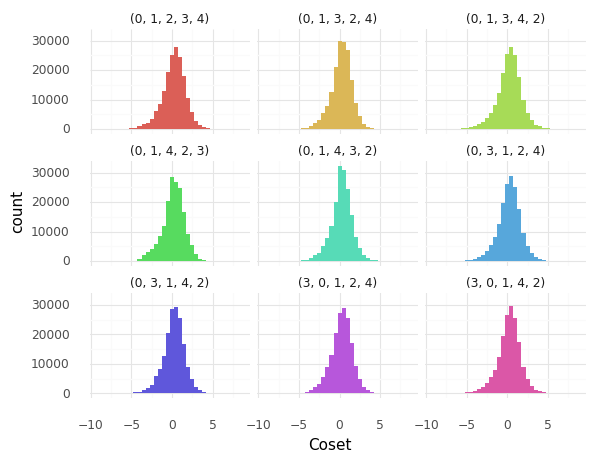

<ggplot: (1374603255)>

In [186]:
from plotnine import scale_y_log10, theme_minimal, geom_violin, geom_density, scale_color_brewer, scale_fill_brewer
fig = (
    ggplot(df_both.filter(pl.col('coset_rep') != '(0, 1, 2, 4, 3)'), aes(x='logit', fill='coset_rep')) 
    + geom_histogram(binwidth=0.5, show_legend=False)
    + facet_wrap('~coset_rep')
    + theme_minimal()
    #+ scale_fill_brewer(type='qual', palette=6)
    #+ theme(text=element_text(size=15), axis_text_x=element_text(angle=45))
    + labs(x ='Coset', fill='Coset')
)
#fig.save('logit_constructive_interference_boxplot.pdf')
fig

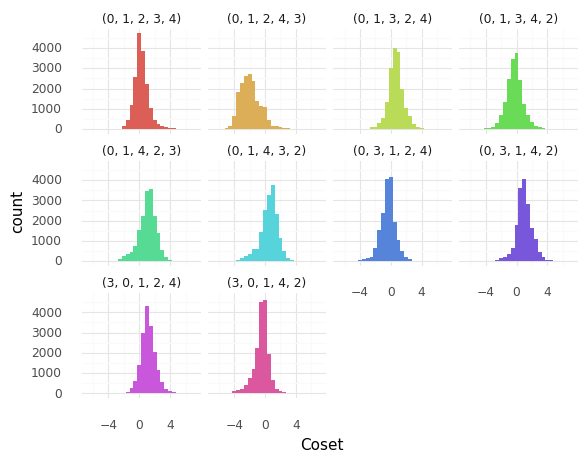

<ggplot: (1388028241)>

In [191]:
fig = (
    ggplot(df_both.filter(pl.col('coset_target') == '(0, 1, 4, 2, 3)'), aes(x='logit', fill='coset_logit')) 
    + geom_histogram(binwidth=0.5, show_legend=False)
    + facet_wrap('~coset_logit')
    + theme_minimal()
    #+ scale_fill_brewer(type='qual', palette=6)
    #+ theme(text=element_text(size=15), axis_text_x=element_text(angle=45))
    + labs(x ='Coset', fill='Coset')
)
#fig.save('logit_constructive_interference_boxplot.pdf')
fig